# Import package

In [157]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
sns.set(style = 'whitegrid',context = 'notebook')

# generate classification report using predictions for categorical model
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn import (metrics,  linear_model, preprocessing)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, learning_curve, StratifiedKFold

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 175)

# Import data

In [158]:
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [159]:
original_df = df.copy()

In [160]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [161]:
df.shape

(768, 9)

# Replace missing values and EDA

In [162]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

### Insulin

In [163]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [164]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = median_target('Insulin').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = median_target('Insulin').iloc[1,1]

### Glucose

In [165]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [166]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = median_target('Glucose').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = median_target('Glucose').iloc[1,1]

### SkinThickness

In [167]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [168]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = median_target('SkinThickness').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = median_target('SkinThickness').iloc[1,1]

### BloodPressure 

In [169]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [170]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = median_target('BloodPressure').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = median_target('BloodPressure').iloc[1,1]

### BMI

In [171]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [172]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = median_target('BMI').iloc[0,1]
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = median_target('BMI').iloc[1,1]

In [173]:
countvar=df.count()
meanvar=np.round(df.mean(),1)
minvar=df.min()
maxvar=df.max()
stdvar=np.round(df.std(),1)
# merge above Series' objects into a data frame, so that it is easy to check and operate
statistics=pd.concat([meanvar, minvar, maxvar, stdvar, countvar], axis=1)  
# remove the index of the data frame
des_stat_df=pd.DataFrame(statistics).reset_index()
# return the name list of the data frame
orname=list(des_stat_df.columns.values)
# rename the data frame
des_stat_df.rename(columns={orname[0]: 'variable', orname[1]: 'mean', 
                   orname[2]: 'min', orname[3]: 'max',
                   orname[4]: 'std',orname[5]: 'non_missing'},                  
                   inplace = True)
# get the total row number and append the column
des_stat_df['totcount']=df['Outcome'].count()
#calculate missing percentage
des_stat_df['miss_per']=np.round(100*(des_stat_df['totcount']-des_stat_df['non_missing'])/des_stat_df['totcount'],1)
des_stat_df

,variable,mean,min,max,std,non_missing,totcount,miss_per
0,Pregnancies,3.8,0.000,17.00,3.4,768,768,0.0
1,Glucose,121.7,44.000,199.00,30.5,768,768,0.0
2,BloodPressure,72.4,24.000,122.00,12.1,768,768,0.0
3,SkinThickness,29.1,7.000,99.00,8.9,768,768,0.0
4,Insulin,141.8,14.000,846.00,89.1,768,768,0.0
5,BMI,32.4,18.200,67.10,6.9,768,768,0.0
6,DiabetesPedigreeFunction,0.5,0.078,2.42,0.3,768,768,0.0
7,Age,33.2,21.000,81.00,11.8,768,768,0.0
8,Outcome,0.3,0.000,1.00,0.5,768,768,0.0


## Numerical variables

#### Create a sub-dataframe to store all numeric variables

In [174]:
# Create a sub-dataframe to store all numeric variables in the whole data frame
datatypes= ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = df.drop(['Outcome'],axis=1).select_dtypes(include=datatypes)
target = df.Outcome

numpredictor = numdf.columns
print(numpredictor)
numdf.head()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


#### Scaling dataset

In [175]:
from sklearn.preprocessing import StandardScaler
numdf_norm = pd.DataFrame(StandardScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns
numdf_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.864625,-0.032180,0.665181,0.311604,0.169483,0.468492,1.425995
1,-0.844885,-1.204727,-0.528124,-0.010112,-0.440843,-0.848549,-0.365061,-0.190672
2,1.233880,2.014265,-0.693438,0.327535,0.311604,-1.328478,0.604397,-0.105584
3,-0.844885,-1.073339,-0.528124,-0.685405,-0.536303,-0.630399,-0.920763,-1.041549
4,-1.141852,0.503310,-2.677212,0.665181,0.294758,1.551096,5.484909,-0.020496


In [176]:
numdf_norm.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,2.544261e-17,1.604619e-16,-3.685926e-16,-3.928426e-17,-8.601337e-18,1.054567e-16,2.398978e-16,1.857600e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-2.551447e+00,-3.999727e+00,-2.486187e+00,-1.434747e+00,-2.070186e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-7.202356e-01,-6.934382e-01,-4.603073e-01,-4.408430e-01,-7.176590e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.536274e-01,-3.218035e-02,-1.226607e-01,-4.408430e-01,-5.593870e-02,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.100618e-01,6.290775e-01,3.275348e-01,3.116039e-01,6.057816e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.539814e+00,4.100681e+00,7.868309e+00,7.909072e+00,5.041489e+00,5.883565e+00,4.063716e+00


In [177]:
from sklearn.preprocessing import MinMaxScaler
numdf_norm = pd.DataFrame(MinMaxScaler().fit_transform(numdf))
numdf_norm.columns = numdf.columns
numdf_norm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.670968,0.489796,0.304348,0.186899,0.314928,0.234415,0.483333
1,0.058824,0.264516,0.428571,0.239130,0.106370,0.171779,0.116567,0.166667
2,0.470588,0.896774,0.408163,0.271739,0.186899,0.104294,0.253629,0.183333
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000


In [178]:
numdf_norm.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.501142,0.493769,0.240107,0.153550,0.291097,0.168179,0.204015
std,0.198210,0.196543,0.123531,0.096639,0.107092,0.140705,0.141473,0.196004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.106370,0.190184,0.070773,0.050000
50%,0.176471,0.470968,0.489796,0.228261,0.106370,0.283231,0.125747,0.133333
75%,0.352941,0.620968,0.571429,0.271739,0.186899,0.376278,0.234095,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Combine all predictors (numeric ones and dummy variables generated above)

In [179]:
X = numdf_norm
print (X.shape)
Y = df['Outcome']
print (Y.shape)

(768, 8)
(768,)


In [180]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.670968,0.489796,0.304348,0.186899,0.314928,0.234415,0.483333
1,0.058824,0.264516,0.428571,0.239130,0.106370,0.171779,0.116567,0.166667
2,0.470588,0.896774,0.408163,0.271739,0.186899,0.104294,0.253629,0.183333
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000


## Spliting data into training and test set

In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [182]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

# Train and perform cross validation

In [183]:
from sklearn import svm
from sklearn.svm import SVC

model = svm.SVC(kernel = 'rbf')

kfold = KFold(n_splits = 10, random_state = 10)
scores = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
scores

array([0.75806452, 0.66129032, 0.82258065, 0.79032258, 0.75409836,
       0.81967213, 0.80327869, 0.72131148, 0.75409836, 0.81967213])

In [184]:
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 77.04% (+/- 9.81%)


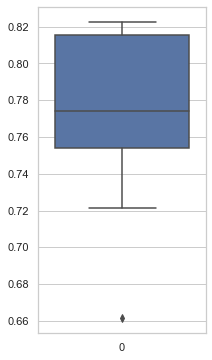

In [185]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

# Prediction

In [186]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
# prob_train_pred = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
# prob_test_pred = model.predict_proba(X_test)

In [187]:
# default parameters
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Model Evaluation

### Accuracy

In [188]:
accuracy_score(y_train, y_train_pred)

0.7719869706840391

In [189]:
accuracy_score(y_test, y_test_pred)

0.8116883116883117

### Confusion matrix

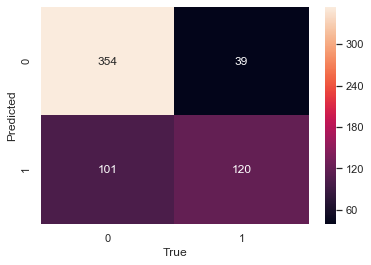

In [190]:
cm_df = pd.DataFrame(confusion_matrix(y_train, y_train_pred))
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

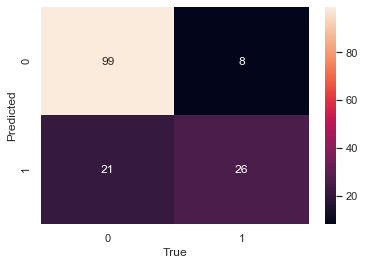

In [191]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
sns.heatmap(cm_df, annot=True, fmt="d")
plt.show()

### Classification Report

In [192]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       393
           1       0.75      0.54      0.63       221

    accuracy                           0.77       614
   macro avg       0.77      0.72      0.73       614
weighted avg       0.77      0.77      0.76       614



In [193]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       107
           1       0.76      0.55      0.64        47

    accuracy                           0.81       154
   macro avg       0.79      0.74      0.76       154
weighted avg       0.81      0.81      0.80       154



### ROC AUC Score

In [194]:
roc_auc_score(y_train, y_train_pred)

0.7218748920589961

In [195]:
roc_auc_score(y_test, y_test_pred)

0.7392125671107577

### ROC Curve

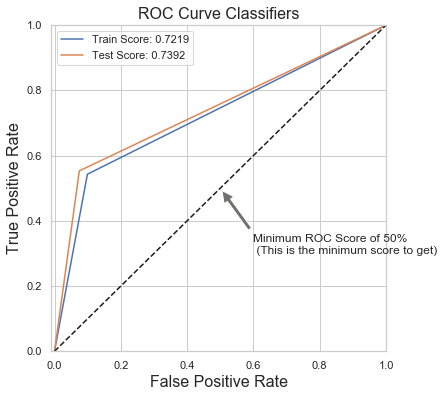

In [196]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, threshold = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, threshold = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(6,6))
plt.title('ROC Curve Classifiers', fontsize=16)
plt.plot(fpr_train, tpr_train, label= 'Train Score: {:.4f}'.format(roc_auc_score(y_train, y_train_pred)))
plt.plot(fpr_test, tpr_test, label= 'Test Score: {:.4f}'.format(roc_auc_score(y_test, y_test_pred)))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05))
plt.legend()
        
plt.show()


### Precision-Recall curve

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.76')

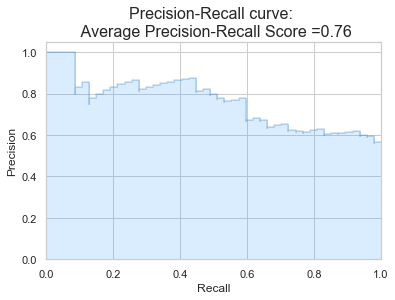

In [197]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_test)
precision, recall, threshold = precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

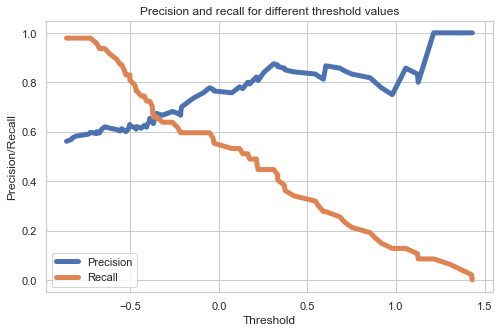

In [198]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.74')

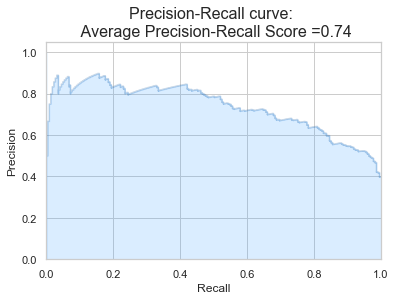

In [199]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

y_score = model.decision_function(X_train)
precision, recall, threshold = precision_recall_curve(y_train,y_score)
average_precision = average_precision_score(y_train, y_score)


plt.step(recall, precision, color='#004a93', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(average_precision), fontsize=16)

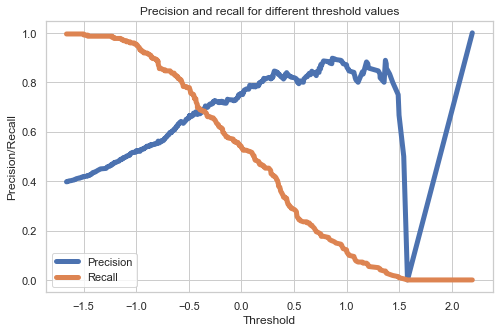

In [200]:
plt.figure(figsize=(8,5))
plt.plot(threshold, precision[1:], label="Precision",linewidth=5)
plt.plot(threshold, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

### Summary

In [141]:
def ModelEvaluation(model,X_train,y_train,X_test,y_test,name):
    print('Model Evaluation of ' + name)

    print('-----------------------------------------------------------')
    print('Train set')
    print('Accuracy: ', accuracy_score(y_train, y_train_pred))
    print('ROC AUC Score: ', roc_auc_score(y_train, y_train_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_train,y_train_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_train, y_train_pred))
    
    print('-----------------------------------------------------------')
    print('Test set')
    print('Accuracy: ', accuracy_score(y_test, y_test_pred))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_test_pred))
    cm_df = pd.DataFrame(confusion_matrix(y_test,y_test_pred), index=model.classes_,columns=model.classes_)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print('Confusion matrix')
    print(cm_df)
    print(classification_report(y_test, y_test_pred))

In [142]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'LinearSVM')

Model Evaluation of LinearSVM
-----------------------------------------------------------
Train set
Accuracy:  0.7719869706840391
ROC AUC Score:  0.7218748920589961
Confusion matrix
True         0    1
Predicted          
0          354   39
1          101  120
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       393
           1       0.75      0.54      0.63       221

    accuracy                           0.77       614
   macro avg       0.77      0.72      0.73       614
weighted avg       0.77      0.77      0.76       614

-----------------------------------------------------------
Test set
Accuracy:  0.8116883116883117
ROC AUC Score:  0.7392125671107577
Confusion matrix
True        0   1
Predicted        
0          99   8
1          21  26
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       107
           1       0.76      0.55      0.64        47

    accuracy            

# Tuning hyper-parameters

In [144]:
param_grid = {
    'C': [1.0, 10.0, 50.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'shrinking': [True, False],
    'gamma': ['auto', 1, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

model_svc = SVC()
grid_search = GridSearchCV(model_svc, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1.0, 10.0, 50.0], 'coef0': [0.0, 0.1, 0.5],
                         'gamma': ['auto', 1, 0.1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [146]:
# Print the bext score found
grid_search.best_score_

0.8501628664495114

In [148]:
best_model = grid_search.best_estimator_
best_model

SVC(C=50.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [150]:
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 76.89% (+/- 8.62%)


In [151]:
scores = cross_val_score(best_model, X_train, y_train, cv=10)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std() * 2))

Accuracy: 85.05% (+/- 11.53%)


In [152]:
scores

array([0.76190476, 0.82258065, 0.85483871, 0.90163934, 0.8852459 ,
       0.90163934, 0.90163934, 0.73770492, 0.90163934, 0.83606557])

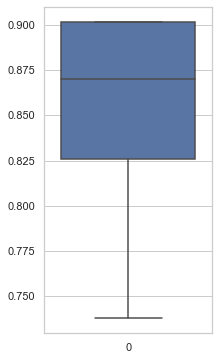

In [153]:
plt.figure(figsize=(3,6))
sns.boxplot(data=scores)
plt.show()

In [155]:
model = best_model

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

In [156]:
ModelEvaluation(model,X_train,y_train,X_test,y_test,'SVM')

Model Evaluation of SVM
-----------------------------------------------------------
Train set
Accuracy:  0.8811074918566775
ROC AUC Score:  0.8556353839245622
Confusion matrix
True         0    1
Predicted          
0          372   21
1           52  169
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       393
           1       0.89      0.76      0.82       221

    accuracy                           0.88       614
   macro avg       0.88      0.86      0.87       614
weighted avg       0.88      0.88      0.88       614

-----------------------------------------------------------
Test set
Accuracy:  0.8441558441558441
ROC AUC Score:  0.8043348578246172
Confusion matrix
True        0   1
Predicted        
0          97  10
1          14  33
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       107
           1       0.77      0.70      0.73        47

    accuracy                  